# Install Pydicom library to read DCM data

In [1]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 1.2MB/s 


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Set Project Path

In [0]:
import os
project_path =  '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection'
os.chdir(project_path)

In [4]:
ls

'GCP Credits Request Link - RSNA.txt'     stage_2_sample_submission.csv
 rsna-pneumonia-detection-challenge.zip   stage_2_test_images/
 stage_2_dcm_data.csv                     stage_2_train_images/
 stage_2_detailed_class_info.csv          stage_2_train_labels.csv
 stage_2_detailed_class_info.gsheet


# Import necessary libraries

In [5]:
import pydicom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import pylab
from tabulate import tabulate
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.cm
from matplotlib import pyplot
from scipy import stats
from glob import glob
from tqdm.auto import tqdm
from IPython.display import display
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Set DCM data path and List unique Patient IDs

In [0]:
data_dir = os.path.join(project_path,"stage_2_train_images")
patient_ids = [ids.split(".")[0] for ids in os.listdir(data_dir)]

In [39]:
print("Total Patient IDs: %d" %len(patient_ids))

Total Patient IDs: 26684


# Load annotation data

In [0]:
bbox_dataframe = pd.read_csv(os.path.join(project_path,"stage_2_train_labels.csv")).reset_index()
target_label_dataframe = pd.read_csv(os.path.join(project_path,"stage_2_detailed_class_info.csv")).reset_index()
target_label_dataframe = target_label_dataframe.drop_duplicates(subset='patientId')

In [41]:
bbox_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      30227 non-null  int64  
 1   patientId  30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 1.6+ MB


In [42]:
bbox_dataframe.sample(5)

,index,patientId,x,y,width,height,Target
7681,7681,5902e358-40b5-42c6-8b77-a6a02f9a9e7c,NaN,NaN,NaN,NaN,0
20744,20744,bd04fa63-5ecd-42da-bf2f-6214896bfc3e,NaN,NaN,NaN,NaN,0
2452,2452,3208e231-f146-41b6-b726-1d4267728342,220.0,610.0,179.0,199.0,1
559,559,0892a3a9-1345-42b3-8412-b930fd9066e5,NaN,NaN,NaN,NaN,0
8019,8019,5bfa4ba1-9ea6-42c5-b44f-1a58dfe648bf,NaN,NaN,NaN,NaN,0


In [43]:
target_label_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      26684 non-null  int64 
 1   patientId  26684 non-null  object
 2   class      26684 non-null  object
dtypes: int64(1), object(2)
memory usage: 833.9+ KB


In [44]:
target_label_dataframe.head(10)

,index,patientId,class
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
10,10,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal
11,11,009482dc-3db5-48d4-8580-5c89c4f01334,Normal


# Merge the annotation data

In [46]:
merged_bbox_target_data = target_label_dataframe.merge(bbox_dataframe, left_on='patientId', right_on='patientId', how='inner')
merged_bbox_target_data.head(10)

,index_x,patientId,class,index_y,x,y,width,height,Target
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0,NaN,NaN,NaN,NaN,0
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,1,NaN,NaN,NaN,NaN,0
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,2,NaN,NaN,NaN,NaN,0
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,3,NaN,NaN,NaN,NaN,0
4,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,4,264.0,152.0,213.0,379.0,1
5,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,5,562.0,152.0,256.0,453.0,1
6,6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,6,NaN,NaN,NaN,NaN,0
7,7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,7,NaN,NaN,NaN,NaN,0
8,8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,8,323.0,577.0,160.0,104.0,1
9,8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,9,695.0,575.0,162.0,137.0,1


# Load sample DCM Data

In [47]:
sample_patient_id = 5
sample_dcm_file = os.path.join(data_dir,patient_ids[5]+".dcm")
sample_dcm_data = pydicom.dcmread(sample_dcm_file)
sample_dcm_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.19677.1517874419.256082
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.19677.1517874419.256082
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

# Tag/Element Key Names in DCM Data

In [48]:
sample_dcm_data.dir()

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

# Convert DCM data to Pandas dataframe and CSV file

In [0]:
# Generates CSV File for DCM Data

# dcm_data_list = []
# for file in tqdm(glob(data_dir+"/*.dcm")):
#   dcm_current_data = pydicom.dcmread(file)
#   dcm_data_list.append({
#       'PatientID': dcm_current_data.PatientID,
#       'Modality': dcm_current_data.Modality,
#       'Sex': dcm_current_data.PatientSex,
#       'Age': dcm_current_data.PatientAge,
#       'BodyPart': dcm_current_data.BodyPartExamined,
#       'ViewPosition': dcm_current_data.ViewPosition
#   })

# columns = ['PatientID','Modality','Sex','Age','BodyPart','ViewPosition']
# dcm_dataframe = pd.DataFrame(dcm_data_list,columns=columns)

# dcm_csv_filename = os.path.join(project_path,"stage_2_dcm_data.csv")
# dcm_dataframe.to_csv(dcm_csv_filename)

# Load DCM data from CSV

In [0]:
columns = ['PatientID','Modality','Sex','Age','BodyPart','ViewPosition']
dcm_dataframe = pd.read_csv(os.path.join(project_path,"stage_2_dcm_data.csv"),index_col=0)

In [34]:
dcm_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 26683
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PatientID     26684 non-null  object
 1   Modality      26684 non-null  object
 2   Sex           26684 non-null  object
 3   Age           26684 non-null  int64 
 4   BodyPart      26684 non-null  object
 5   ViewPosition  26684 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


In [35]:
dcm_dataframe.head(5)

,PatientID,Modality,Sex,Age,BodyPart,ViewPosition
0,f79e5a75-5e15-431a-9ba3-de64c1724b65,CR,M,59,CHEST,PA
1,f79fa94e-8886-425c-95d4-81abfea92aee,CR,F,43,CHEST,PA
2,f79fc759-fde0-4e2e-8951-26ac8af5ef89,CR,F,45,CHEST,AP
3,f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9,CR,M,52,CHEST,PA
4,f7a172fc-a34f-4155-806d-7b0afe2a6156,CR,M,26,CHEST,AP


# Merge DCM data with annotatiion data excluding bounding box for EDA

In [55]:
patient_label_data_without_bbox = target_label_dataframe.merge(bbox_dataframe[['patientId','Target']], left_on='patientId', right_on='patientId', how='inner')
patient_label_data_without_bbox =  patient_label_data_without_bbox.drop_duplicates()

merged_patient_data_without_bbox = patient_label_data_without_bbox.merge(dcm_dataframe, left_on='patientId', right_on='PatientID', how='inner')
merged_patient_data_without_bbox = merged_patient_data_without_bbox.astype({'Age':int})
merged_patient_data_without_bbox = merged_patient_data_without_bbox.drop(['PatientID', 'index'],axis=1)
merged_patient_data_without_bbox.head(10)

,patientId,class,Target,Modality,Sex,Age,BodyPart,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0,CR,F,51,CHEST,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,0,CR,F,48,CHEST,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,0,CR,M,19,CHEST,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0,CR,M,28,CHEST,PA
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,1,CR,F,32,CHEST,AP
5,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,0,CR,M,54,CHEST,AP
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,0,CR,M,78,CHEST,PA
7,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,1,CR,M,75,CHEST,PA
8,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal,0,CR,F,59,CHEST,PA
9,009482dc-3db5-48d4-8580-5c89c4f01334,Normal,0,CR,M,63,CHEST,PA


# Display Patient Information based on Patient ID

In [0]:
def getPatientInfo(patient_id, print_dcm = True, plot_xray = True, plot_bbox = True):
  dcm_file = os.path.join(data_dir,"%s.dcm" %patient_id)
  dcm_data = pydicom.read_file(dcm_file)

  if (print_dcm == True):
    temp_data = pd.DataFrame(dcm_dataframe[dcm_dataframe['PatientID'] == patient_id])
    temp_data['Condition type'] = merged_patient_data_without_bbox[merged_patient_data_without_bbox['patientId'] == patient_id]['class'].values[0]
    temp_data['Pneumonia'] = 'Yes' if merged_patient_data_without_bbox[merged_patient_data_without_bbox['patientId'] == patient_id]['Target'].values[0] == 1 else 'No'
    temp_data.set_index('PatientID',inplace=True)
    display(temp_data.T)

  if (plot_xray == True):
    image = dcm_data.pixel_array
    im = Image.fromarray(image.astype(np.uint8))
    fig, ax = pyplot.subplots()
    ax.imshow(im, cmap=matplotlib.cm.bone)
    ax.axis("off")
    if (plot_bbox == True):
      rows = merged_bbox_target_data[merged_bbox_target_data['patientId'] == patient_id]
      bboxes = list(rows.T.to_dict().values())

      for i,row in enumerate(bboxes):
        ax.add_patch(Rectangle(xy = (row['x'], row['y']), width=row['width'],height=row['height'], color='green', alpha=0.2))

There are different kinds of opacities (see a general explanation about opacities below). Some are related to pneumonia and some are not. What we see in the image of Patient 5 are Lung Nodules and Masses, which are defined as "*A rounded opacity, well or poorly defined*" - **Felson's Principles of Chest Roentgenology (Fourth Edition)**

1. Patient with Lung Opacity


PatientID,f7a172fc-a34f-4155-806d-7b0afe2a6156
Modality,CR
Sex,M
Age,26
BodyPart,CHEST
ViewPosition,AP
Condition type,Lung Opacity
Pneumonia,Yes


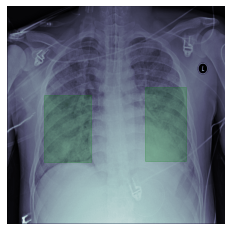

In [58]:
print('1. Patient with Lung Opacity')
getPatientInfo(patient_ids[4])

2. Normal Patient


PatientID,f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9
Modality,CR
Sex,M
Age,52
BodyPart,CHEST
ViewPosition,PA
Condition type,Normal
Pneumonia,No


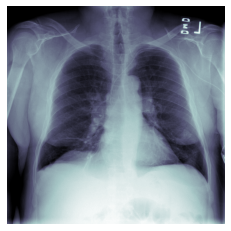

In [59]:
print('2. Normal Patient')
getPatientInfo(patient_ids[3])

1. Patient with No Lung Opacity / Not Normal


PatientID,f7a37b72-fda5-4adc-b3b0-968c923bc1c6
Modality,CR
Sex,F
Age,35
BodyPart,CHEST
ViewPosition,PA
Condition type,No Lung Opacity / Not Normal
Pneumonia,No


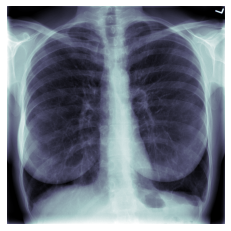

In [60]:
print('1. Patient with No Lung Opacity / Not Normal')
getPatientInfo(patient_ids[6])

# Pneumonia Positive Patient Data

In [0]:
affected_patients = merged_bbox_target_data[merged_bbox_target_data['Target'] == 1]

# Plot describing the aggregated area of X-Rays where the cause of Pneumonia lies

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


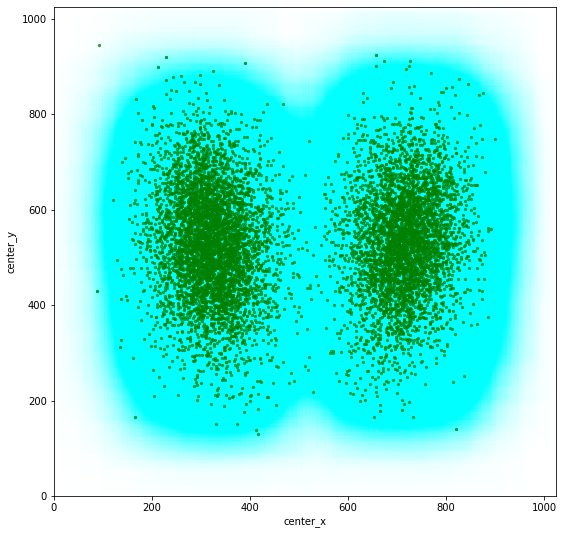

In [63]:
fig, ax = pyplot.subplots(1,1, figsize=(9,9))
affected_patients['center_x'] = affected_patients['x'] + (affected_patients['width'] / 2)
affected_patients['center_y'] = affected_patients['y'] + (affected_patients['height'] / 2)
affected_patients.plot.scatter(x = 'center_x', y = 'center_y', xlim = (0,1024), ylim = (0,1024) , ax = ax, alpha = 0.7, marker=".", color="green")
dict_data = list(affected_patients.T.to_dict().values())
for i , current_data in tqdm(enumerate(dict_data)):
  ax.add_patch(Rectangle(xy = (current_data['x'], current_data['y']), width=current_data['width'], height=current_data['height'], alpha = 4e-3, color="cyan"))


# Age distribution of Patients

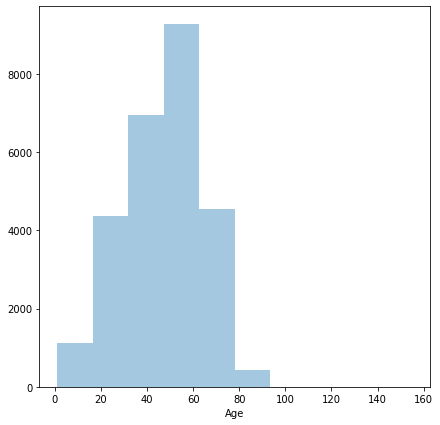

In [64]:
plt.figure(figsize=(7,7))
sns.distplot(merged_patient_data_without_bbox['Age'], bins=10, kde=False)

plt.show()

# Pneumonia Positive and Negative cases

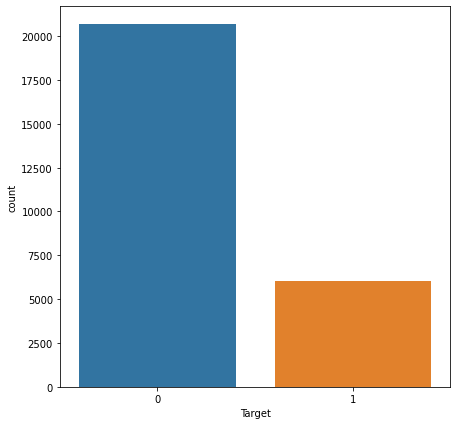

In [65]:
plt.figure(figsize=(7,7))
sns.countplot(x='Target',data=merged_patient_data_without_bbox)

# Patients with pneumonia outcome with respect to age

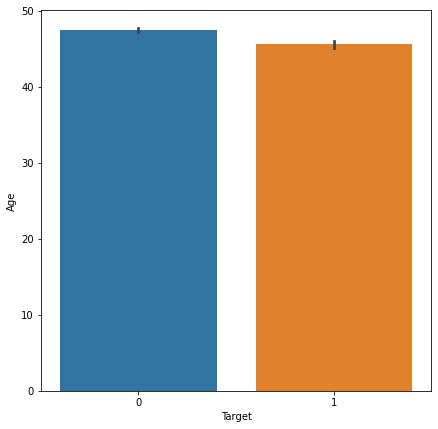

In [66]:
plt.figure(figsize=(7,7))
sns.barplot(x='Target',y='Age',data=merged_patient_data_without_bbox)

# Check for the dependance of Age of Patients with Pneumonia Outcome

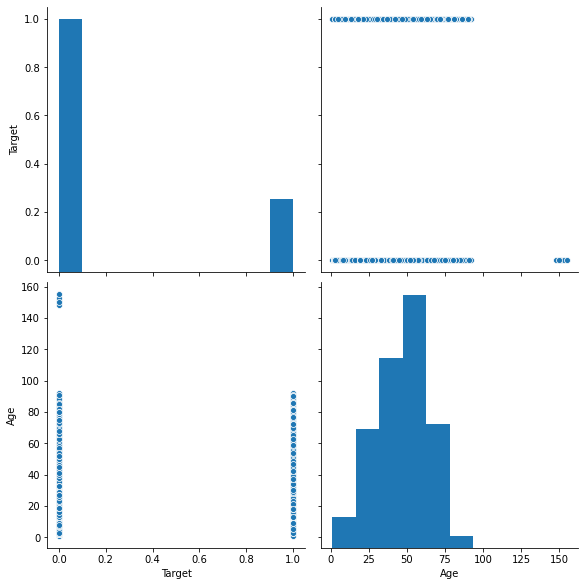

In [67]:
temp_plot = sns.pairplot(merged_patient_data_without_bbox, height=4)

# Split of detailed classifications in the training set

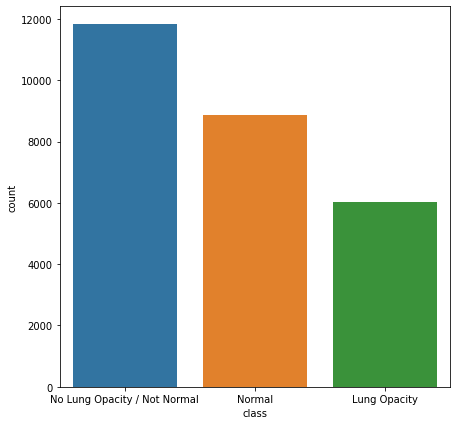

In [68]:
plt.figure(figsize=(7,7))
sns.countplot(x='class',data=merged_patient_data_without_bbox)

# Division of pneumonia patients with respect to their sex

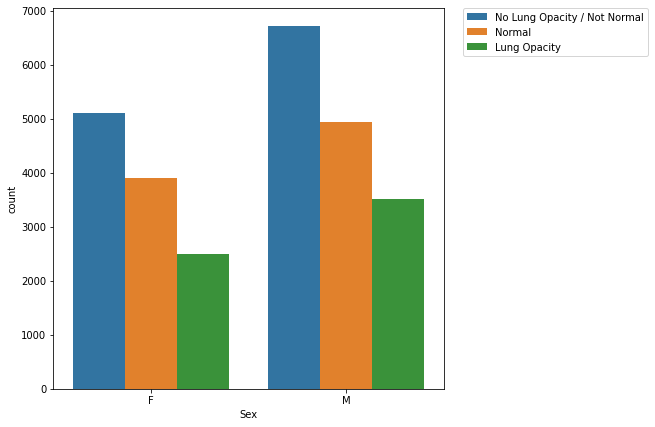

In [69]:
plt.figure(figsize=(7,7))
sns.countplot(x='Sex',hue='class',data=merged_patient_data_without_bbox)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

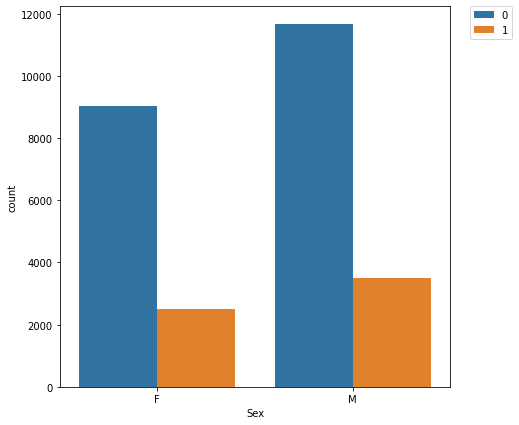

In [70]:
plt.figure(figsize=(7,7))
sns.countplot(x='Sex',hue='Target',data=merged_patient_data_without_bbox)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Check for Outliers in Patient's Age

Missing Values : 0
Number of Outliers : 0


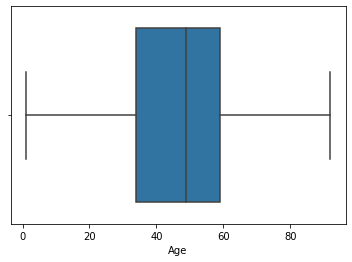

In [84]:
temp_age_data = merged_patient_data_without_bbox['Age']
q1=temp_age_data.quantile(0.25)
q3=temp_age_data.quantile(0.75)
print('Missing Values :',temp_age_data.isnull().sum())
IQR=q3-q1
outlier_count = ((temp_age_data.iloc[:] <(q1-1.5*IQR))|(temp_age_data.iloc[:]>(q3+1.5*IQR))).sum(axis=0)
print('Number of Outliers :',outlier_count)
sns.boxplot(temp_age_data)

In [85]:
average_age = temp_age_data.mean()
print("Average Age: %s" %average_age)

Average Age: 47.01046132850927


# Replace the outliers with Average Age

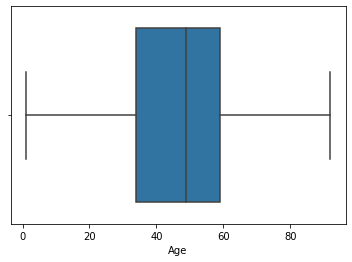

In [86]:
merged_patient_data_without_bbox.loc[(AgeData.iloc[:] <(q1-1.5*IQR))|(AgeData.iloc[:]>(q3+1.5*IQR)),"Age"] = average_age
sns.boxplot(merged_patient_data_without_bbox['Age'])

# Check for X-Rays of unique body parts

In [87]:
print('X-Ray of',merged_patient_data_without_bbox.BodyPart.unique(),'are available')

X-Ray of ['CHEST'] are available


# Check for Unique View Positions of X-Ray

Following X-Ray views are available ['PA' 'AP']


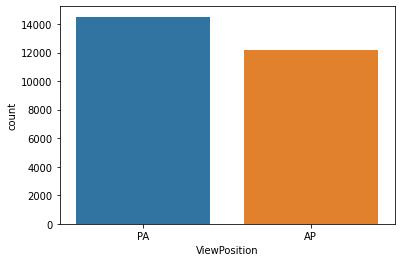

In [89]:
print('Following X-Ray views are available',merged_patient_data_without_bbox.ViewPosition.unique())
sns.countplot(x='ViewPosition',data=merged_patient_data_without_bbox)

1. PA :
* The posteroanterior (PA) view is the standard frontal chest projection
* The x-ray beam traverses the patient from posterior to anterior
* It is performed standing and in full inspiration with the patient hugging the detector to pull the scapulae laterally
2. AP :
* The anteroposterior (AP) erect view is an alternative frontal projection to the PA projection with the beam traversing the patient from anterior to posterior
* It can be performed with the patient sitting up on the bed and even performed outside the radiology department using a mobile x-ray unit

In [0]:
from IPython.display import Image as notebook_image

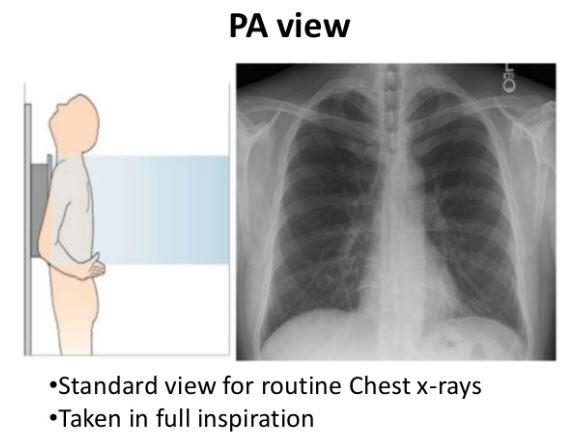

In [92]:
notebook_image(os.path.join(project_path,"PA_View.jpeg"))

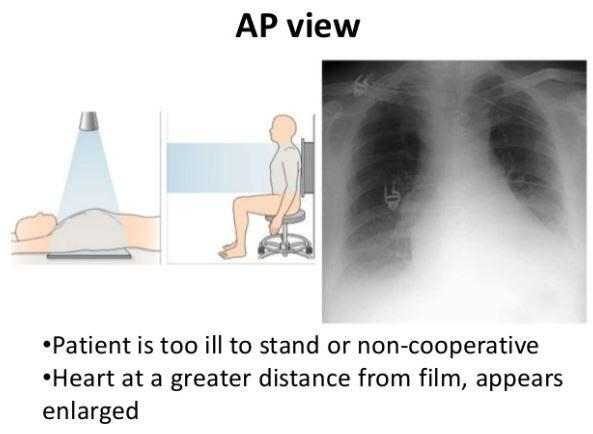

In [93]:
notebook_image(os.path.join(project_path,"AP_View.jpeg"))